In [ ]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from imblearn.over_sampling import RandomOverSampler

import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
training_dataset = pd.read_csv("/kaggle/input/bttai-ajl-2025/train.csv")
testing_dataset = pd.read_csv("/kaggle/input/bttai-ajl-2025/test.csv")
training_path = '/kaggle/input/bttai-ajl-2025/train/train'
testing_path = '/kaggle/input/bttai-ajl-2025/test/test'
sample_submission = pd.read_csv('/kaggle/input/bttai-ajl-2025/sample_submission.csv')
training_dataset['file_path'] = training_dataset['label'] + '/' + training_dataset['md5hash'] + '.jpg'
testing_dataset['file_path'] = testing_dataset['md5hash'] + '.jpg'
training_dataset['file_path'].loc[0]

'prurigo-nodularis/fd06d13de341cc75ad679916c5d7e6a6.jpg'

In [ ]:
training_dataset.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


In [ ]:
training_dataset.isnull().sum()

md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
file_path                   0
dtype: int64

In [ ]:
training_dataset['qc_encoded'] = training_dataset['qc'].notna().astype(int)
training_dataset.drop('qc', axis=1, inplace=True)
training_dataset.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,ddi_scale,file_path,qc_encoded
0,fd06d13de341cc75ad679916c5d7e6a6,4,4,prurigo-nodularis,benign-epidermal,benign,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...,0
1,a4bb4e5206c4e89a303f470576fc5253,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...,0
2,c94ce27e389f96bda998e7c3fa5c4a2e,5,5,keloid,inflammatory,non-neoplastic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg,1
3,ebcf2b50dd943c700d4e2b586fcd4425,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...,0
4,c77d6c895f05fea73a8f3704307036c0,1,1,prurigo-nodularis,benign-epidermal,benign,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...,0


# See what classes need to be balanced

In [ ]:
training_dataset['fitzpatrick_scale'].unique()

array([ 4,  1,  5,  3,  2, -1,  6])

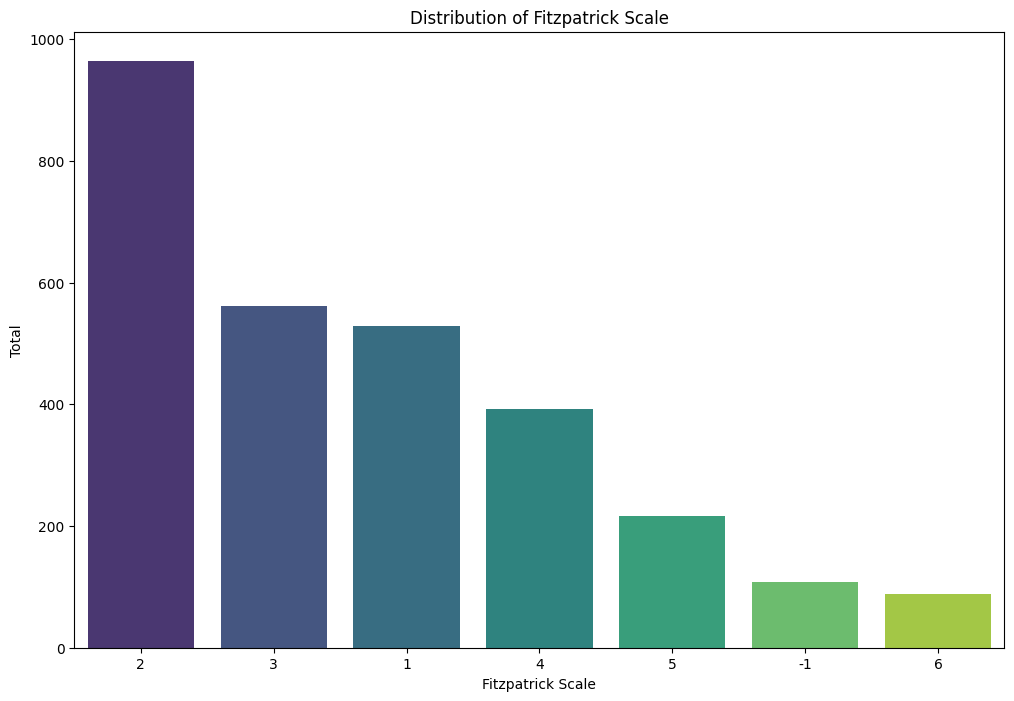

In [ ]:
fitzpatrick_df = training_dataset['fitzpatrick_scale'].value_counts().reset_index()
fitzpatrick_df.columns = ['fitzpatrick_scale', 'count']
fitzpatrick_df = fitzpatrick_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=fitzpatrick_df, x='fitzpatrick_scale', y='count', palette='viridis', order=fitzpatrick_df['fitzpatrick_scale'], dodge=False)
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Total')
plt.title('Distribution of Fitzpatrick Scale')
plt.show()

In [ ]:
training_dataset['fitzpatrick_centaur'].unique()

array([ 4,  1,  5,  3, -1,  2,  6])

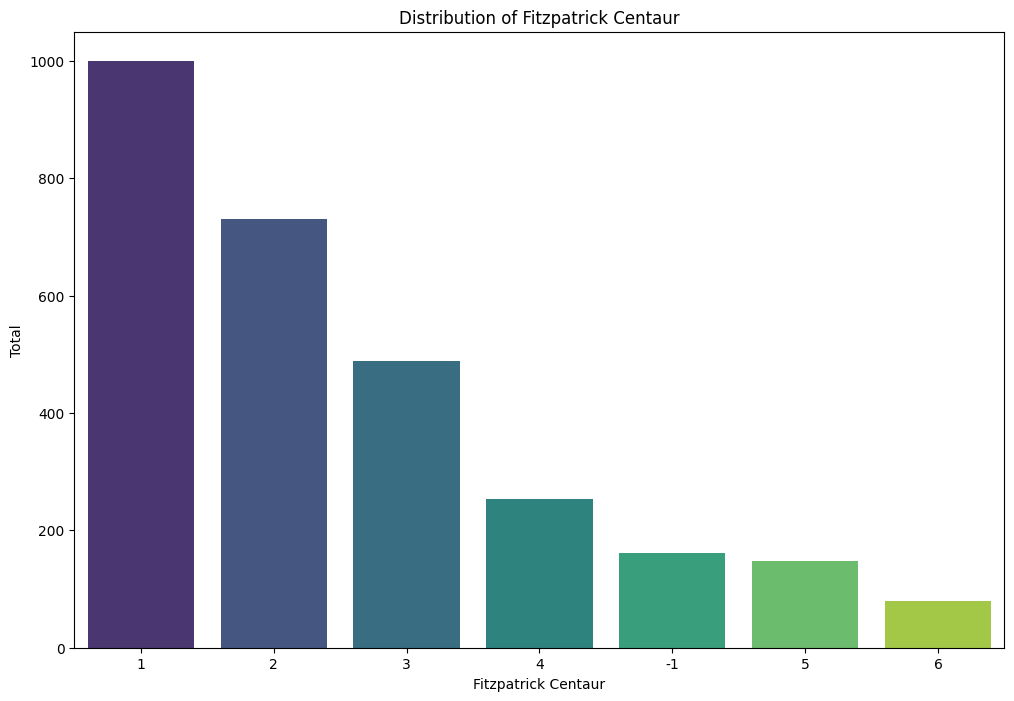

In [ ]:
fitzpatrickCentaur = training_dataset['fitzpatrick_centaur'].value_counts().reset_index()
fitzpatrickCentaur.columns = ['fitzpatrick_centaur', 'count']
fitzpatrickCentaur = fitzpatrickCentaur.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=fitzpatrickCentaur, x='fitzpatrick_centaur', y='count', palette='viridis', order=fitzpatrickCentaur['fitzpatrick_centaur'], dodge=False)
plt.xlabel('Fitzpatrick Centaur')
plt.ylabel('Total')
plt.title('Distribution of Fitzpatrick Centaur')
plt.show()

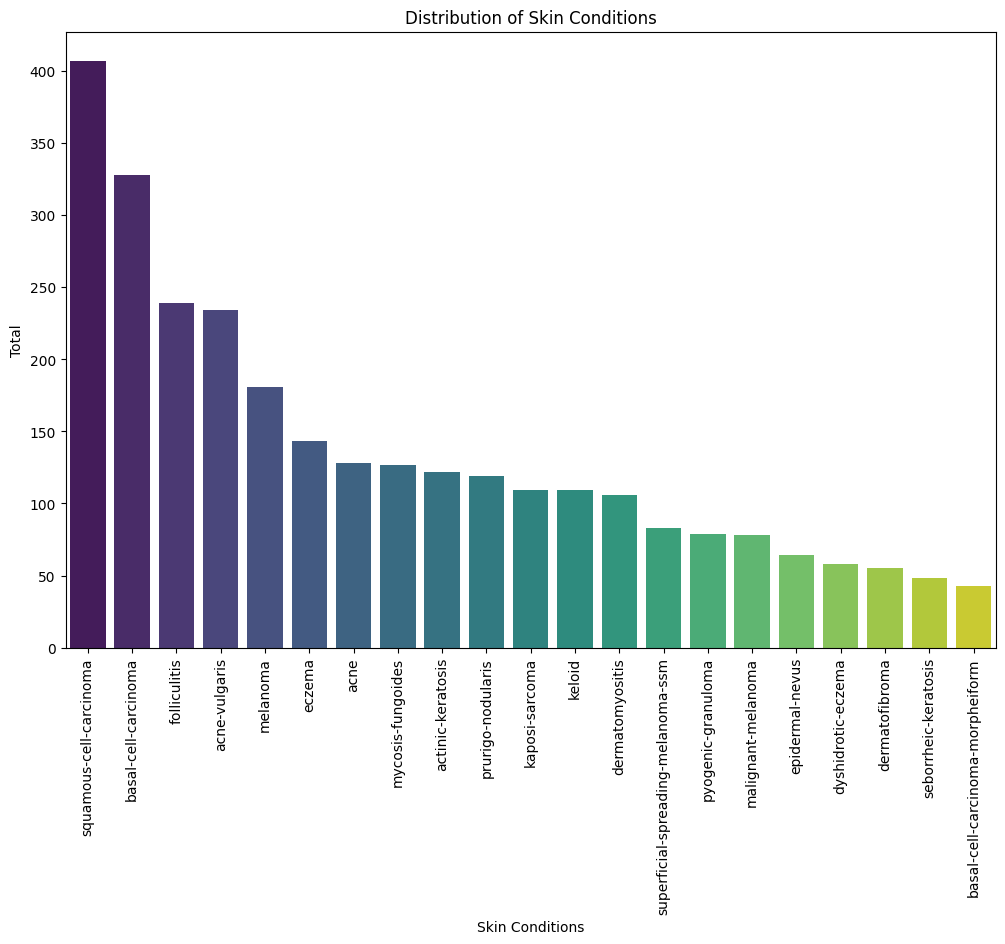

In [ ]:
label_df = training_dataset['label'].value_counts().reset_index()
label_df.columns = ['label', 'count']
label_df = label_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=label_df, x='label', y='count', palette='viridis', order=label_df['label'], dodge=False)
plt.xticks(rotation=90)
plt.xlabel('Skin Conditions')
plt.ylabel('Total')
plt.title('Distribution of Skin Conditions')
plt.show()

# Oversampling based on fitzpatrick scale so minority skin tone data is more prevelant in the dataset

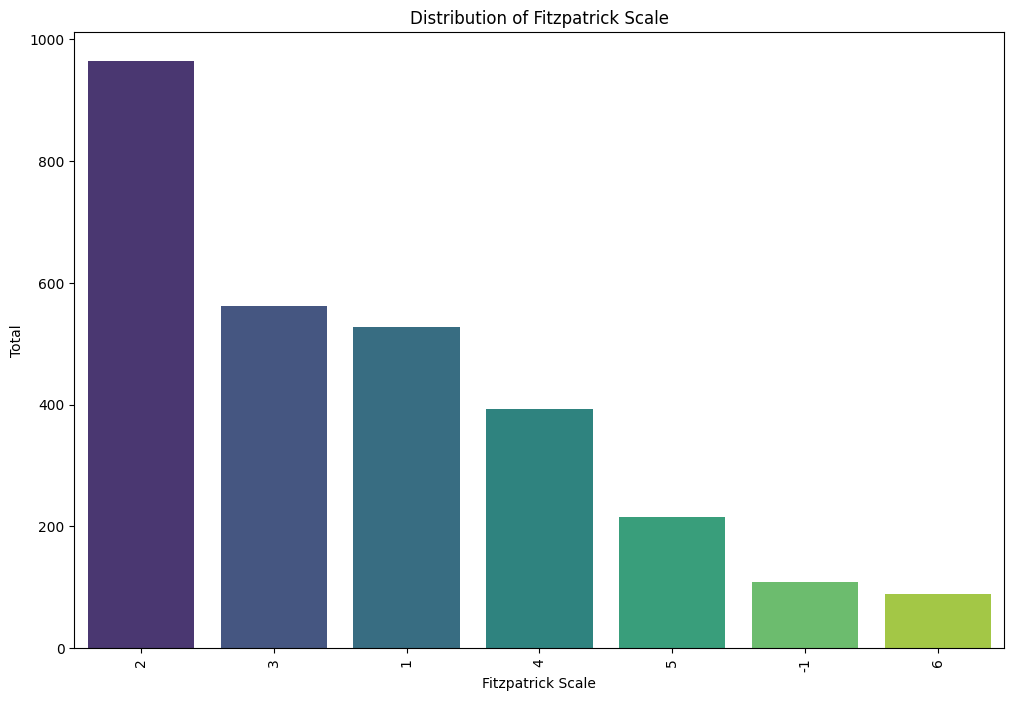

In [ ]:
before_fitz = training_dataset['fitzpatrick_scale'].value_counts().reset_index()
before_fitz.columns = ['fitzpatrick_scale', 'count']
before_fitz = before_fitz.sort_values(by='count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=before_fitz , x='fitzpatrick_scale', y='count', palette='viridis', order=before_fitz['fitzpatrick_scale'], dodge=False)
plt.xticks(rotation=90)
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Total')
plt.title('Distribution of Fitzpatrick Scale')
plt.show()

In [ ]:
training_dataset.groupby(['label', 'fitzpatrick_scale']).size().unstack()

fitzpatrick_scale,-1,1,2,3,4,5,6
label,,,,,,,
acne,NaN,32.0,48.0,22.0,15.0,11.0,NaN
acne-vulgaris,NaN,53.0,104.0,34.0,30.0,9.0,4.0
actinic-keratosis,5.0,21.0,55.0,18.0,15.0,8.0,NaN
basal-cell-carcinoma,8.0,58.0,114.0,81.0,47.0,15.0,5.0
basal-cell-carcinoma-morpheiform,1.0,16.0,21.0,4.0,NaN,1.0,NaN
dermatofibroma,1.0,9.0,25.0,16.0,4.0,NaN,NaN
dermatomyositis,2.0,16.0,39.0,24.0,15.0,6.0,4.0
dyshidrotic-eczema,4.0,12.0,18.0,9.0,8.0,2.0,5.0
eczema,3.0,18.0,65.0,25.0,17.0,8.0,7.0


<Axes: xlabel='label'>

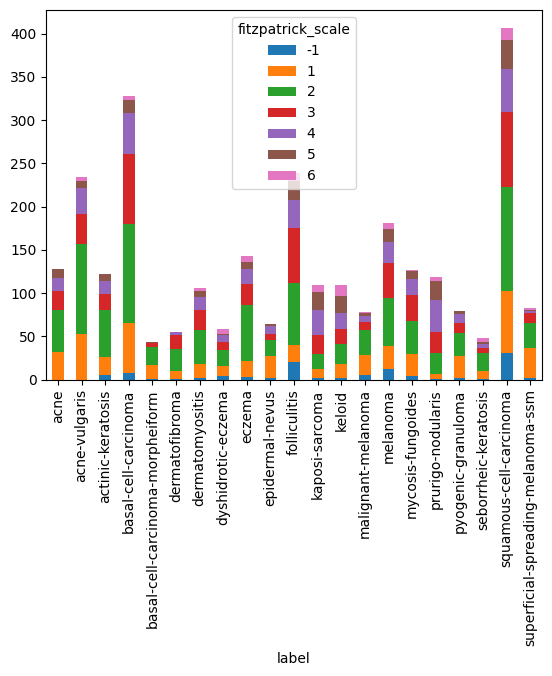

In [ ]:
training_dataset.groupby(['label', 'fitzpatrick_scale']).size().unstack().plot(kind='bar', stacked=True)

In [ ]:
sample_fitzpatrickScale = training_dataset
sample_fitzpatrickScale.sort_values(by='label', inplace=True)
sample_fitzpatrickScale

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,ddi_scale,file_path,qc_encoded
627,aabd3637bc4f2b810e51aa99e4ea4eb7,3,3,acne,inflammatory,non-neoplastic,34,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0
1331,cb2b761d3389b0ca3084a4f12d59a40a,4,5,acne,inflammatory,non-neoplastic,34,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0
504,1053d6a1ce8368ec6020c5a8ab823c11,2,1,acne,inflammatory,non-neoplastic,12,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0
2050,bda3a4932fc1ac8de4c8a4fd146bb503,1,1,acne,inflammatory,non-neoplastic,12,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0
319,2df4c60292d03b1278dac9d602481479,2,1,acne,inflammatory,non-neoplastic,12,acne/2df4c60292d03b1278dac9d602481479.jpg,0
...,...,...,...,...,...,...,...,...,...
1324,c654431b35ae082b8b5ec407fbdc501b,1,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,12,superficial-spreading-melanoma-ssm/c654431b35a...,0
2343,454e68bf5705eabf0f4d28fc1dbd77be,6,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1
1588,b995b00ca0f6e3a5ac881db2d40a5c34,1,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,12,superficial-spreading-melanoma-ssm/b995b00ca0f...,0
1097,1f24cd91d3536af05573c716cee9afe3,1,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,12,superficial-spreading-melanoma-ssm/1f24cd91d35...,0


In [ ]:
def sample_minority(df, labelType):
  sample = df[df['label'] == labelType]
  X_train = sample.drop('fitzpatrick_scale', axis=1)
  y_train = sample['fitzpatrick_scale']
  ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
  X_result, y_result = ros.fit_resample(X_train, y_train)
  resampled_data = pd.concat([pd.DataFrame(X_result, columns=X_train.columns), pd.Series(y_result, name='fitzpatrick_scale')], axis=1)
  return resampled_data

In [ ]:
resampled_fitzpatrickScale = pd.DataFrame()
for i in sample_fitzpatrickScale['label'].unique():
  resampled_fitzpatrickScale = pd.concat([resampled_fitzpatrickScale, sample_minority(sample_fitzpatrickScale, i)], ignore_index=True)

In [ ]:
resampled_fitzpatrickScale.groupby(['label', 'fitzpatrick_scale']).size().unstack()

fitzpatrick_scale,-1,1,2,3,4,5,6
label,,,,,,,
acne,NaN,48.0,48.0,48.0,48.0,48.0,NaN
acne-vulgaris,NaN,104.0,104.0,104.0,104.0,104.0,104.0
actinic-keratosis,55.0,55.0,55.0,55.0,55.0,55.0,NaN
basal-cell-carcinoma,114.0,114.0,114.0,114.0,114.0,114.0,114.0
basal-cell-carcinoma-morpheiform,21.0,21.0,21.0,21.0,NaN,21.0,NaN
dermatofibroma,25.0,25.0,25.0,25.0,25.0,NaN,NaN
dermatomyositis,39.0,39.0,39.0,39.0,39.0,39.0,39.0
dyshidrotic-eczema,18.0,18.0,18.0,18.0,18.0,18.0,18.0
eczema,65.0,65.0,65.0,65.0,65.0,65.0,65.0


<Axes: xlabel='label'>

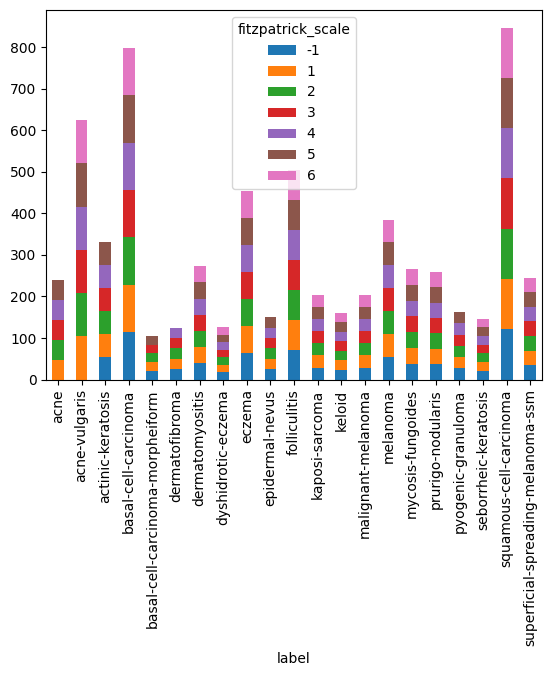

In [ ]:
resampled_fitzpatrickScale.groupby(['label', 'fitzpatrick_scale']).size().unstack().plot(kind='bar', stacked=True)

In [ ]:
training_dataset = resampled_fitzpatrickScale
training_dataset

,md5hash,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,ddi_scale,file_path,qc_encoded,fitzpatrick_scale
0,aabd3637bc4f2b810e51aa99e4ea4eb7,3,acne,inflammatory,non-neoplastic,34,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0,3
1,cb2b761d3389b0ca3084a4f12d59a40a,5,acne,inflammatory,non-neoplastic,34,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0,4
2,1053d6a1ce8368ec6020c5a8ab823c11,1,acne,inflammatory,non-neoplastic,12,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0,2
3,bda3a4932fc1ac8de4c8a4fd146bb503,1,acne,inflammatory,non-neoplastic,12,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0,1
4,2df4c60292d03b1278dac9d602481479,1,acne,inflammatory,non-neoplastic,12,acne/2df4c60292d03b1278dac9d602481479.jpg,0,2
...,...,...,...,...,...,...,...,...,...
6603,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6
6604,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6
6605,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6
6606,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6


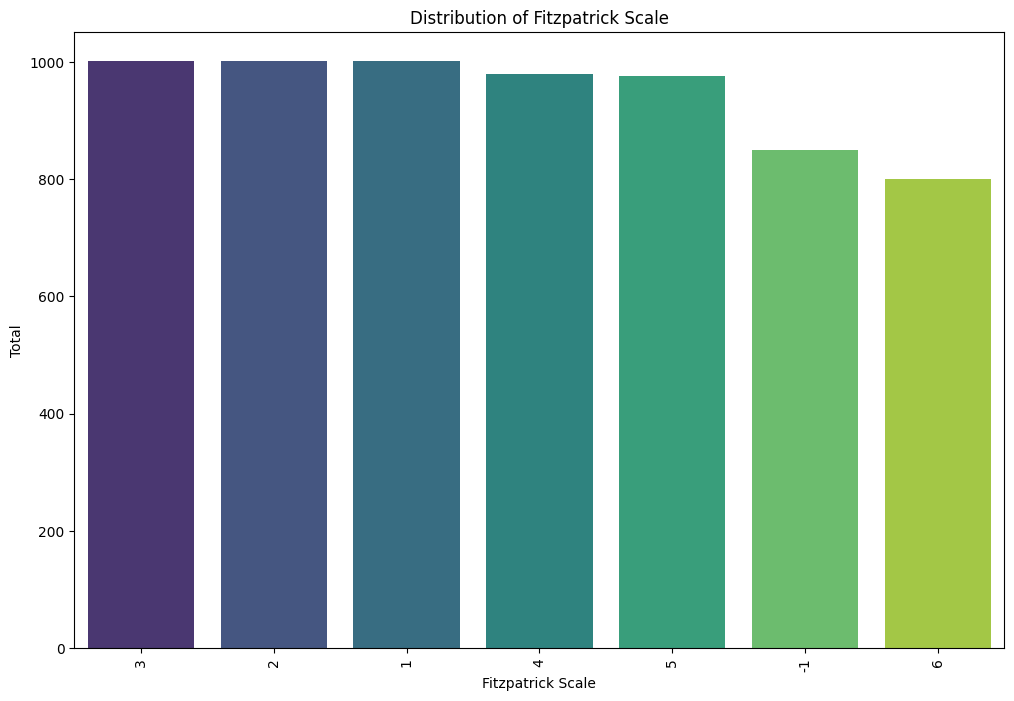

In [ ]:
before_fitz = training_dataset['fitzpatrick_scale'].value_counts().reset_index()
before_fitz.columns = ['fitzpatrick_scale', 'count']
before_fitz = before_fitz.sort_values(by='count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=before_fitz , x='fitzpatrick_scale', y='count', palette='viridis', order=before_fitz['fitzpatrick_scale'], dodge=False)
plt.xticks(rotation=90)
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Total')
plt.title('Distribution of Fitzpatrick Scale')
plt.show()

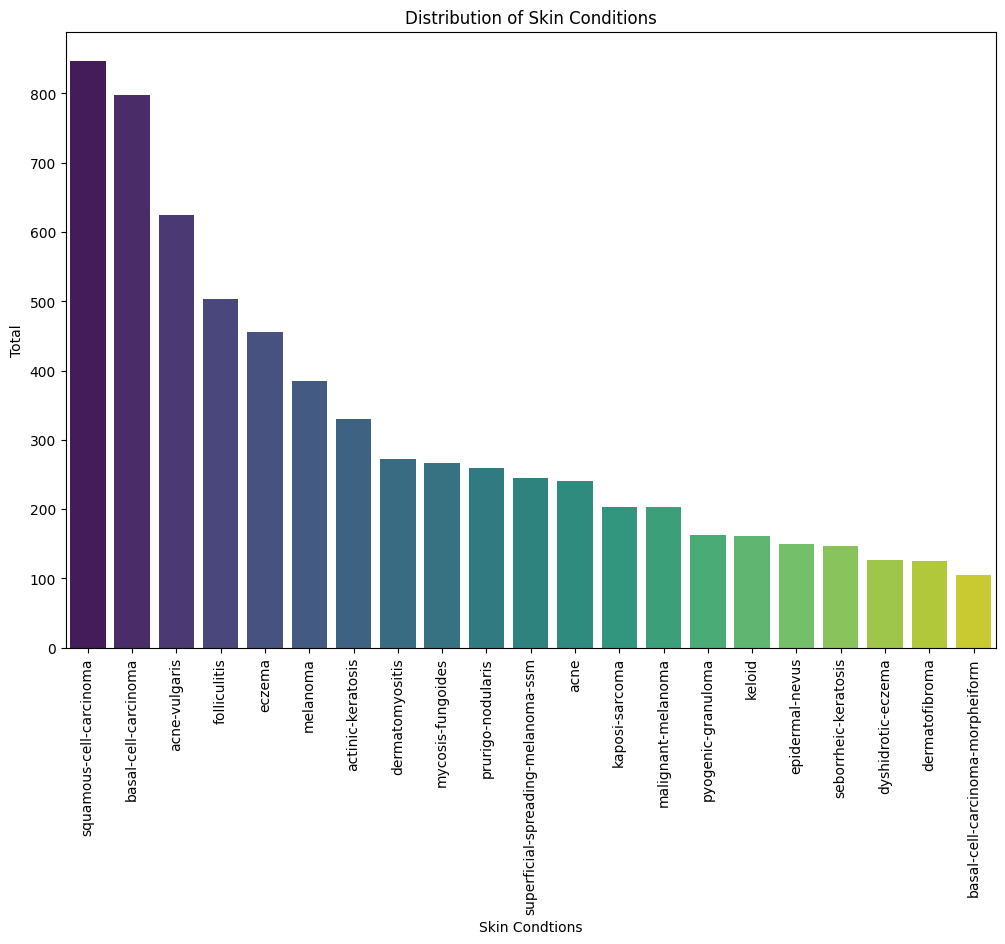

In [ ]:
after_fitz = training_dataset['label'].value_counts().reset_index()
after_fitz.columns = ['label', 'count']
after_fitz = after_fitz.sort_values(by='count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=after_fitz , x='label', y='count', palette='viridis', order=after_fitz['label'], dodge=False)
plt.xticks(rotation=90)
plt.xlabel('Skin Condtions')
plt.ylabel('Total')
plt.title('Distribution of Skin Conditions')
plt.show()

# Encoding

In [ ]:
training_dataset.dtypes

md5hash                  object
fitzpatrick_centaur       int64
label                    object
nine_partition_label     object
three_partition_label    object
ddi_scale                 int64
file_path                object
qc_encoded                int64
fitzpatrick_scale         int64
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
training_dataset['encoded_label'] = label_encoder.fit_transform(training_dataset['label'])
training_dataset.head()

,md5hash,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,ddi_scale,file_path,qc_encoded,fitzpatrick_scale,encoded_label
0,aabd3637bc4f2b810e51aa99e4ea4eb7,3,acne,inflammatory,non-neoplastic,34,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0,3,0
1,cb2b761d3389b0ca3084a4f12d59a40a,5,acne,inflammatory,non-neoplastic,34,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0,4,0
2,1053d6a1ce8368ec6020c5a8ab823c11,1,acne,inflammatory,non-neoplastic,12,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0,2,0
3,bda3a4932fc1ac8de4c8a4fd146bb503,1,acne,inflammatory,non-neoplastic,12,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0,1,0
4,2df4c60292d03b1278dac9d602481479,1,acne,inflammatory,non-neoplastic,12,acne/2df4c60292d03b1278dac9d602481479.jpg,0,2,0


In [ ]:
skin_Conditions = pd.get_dummies(training_dataset['label'], prefix='label_', dtype=int)
skin_Conditions

,label__acne,label__acne-vulgaris,label__actinic-keratosis,label__basal-cell-carcinoma,label__basal-cell-carcinoma-morpheiform,label__dermatofibroma,label__dermatomyositis,label__dyshidrotic-eczema,label__eczema,label__epidermal-nevus,...,label__kaposi-sarcoma,label__keloid,label__malignant-melanoma,label__melanoma,label__mycosis-fungoides,label__prurigo-nodularis,label__pyogenic-granuloma,label__seborrheic-keratosis,label__squamous-cell-carcinoma,label__superficial-spreading-melanoma-ssm
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
training_dataset = training_dataset.join(skin_Conditions)
##dropping encoded_label since we one hot encoded -uma
training_dataset

,md5hash,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,ddi_scale,file_path,qc_encoded,fitzpatrick_scale,encoded_label,...,label__kaposi-sarcoma,label__keloid,label__malignant-melanoma,label__melanoma,label__mycosis-fungoides,label__prurigo-nodularis,label__pyogenic-granuloma,label__seborrheic-keratosis,label__squamous-cell-carcinoma,label__superficial-spreading-melanoma-ssm
0,aabd3637bc4f2b810e51aa99e4ea4eb7,3,acne,inflammatory,non-neoplastic,34,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,cb2b761d3389b0ca3084a4f12d59a40a,5,acne,inflammatory,non-neoplastic,34,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0,4,0,...,0,0,0,0,0,0,0,0,0,0
2,1053d6a1ce8368ec6020c5a8ab823c11,1,acne,inflammatory,non-neoplastic,12,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,bda3a4932fc1ac8de4c8a4fd146bb503,1,acne,inflammatory,non-neoplastic,12,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2df4c60292d03b1278dac9d602481479,1,acne,inflammatory,non-neoplastic,12,acne/2df4c60292d03b1278dac9d602481479.jpg,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6603,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,...,0,0,0,0,0,0,0,0,0,1
6604,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,...,0,0,0,0,0,0,0,0,0,1
6605,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,...,0,0,0,0,0,0,0,0,0,1
6606,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,malignant-melanoma,malignant,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
one_hotEncoded_labels =  [col for col in training_dataset.columns if col.startswith("label_")]
one_hotEncoded_labels

['label__acne',
 'label__acne-vulgaris',
 'label__actinic-keratosis',
 'label__basal-cell-carcinoma',
 'label__basal-cell-carcinoma-morpheiform',
 'label__dermatofibroma',
 'label__dermatomyositis',
 'label__dyshidrotic-eczema',
 'label__eczema',
 'label__epidermal-nevus',
 'label__folliculitis',
 'label__kaposi-sarcoma',
 'label__keloid',
 'label__malignant-melanoma',
 'label__melanoma',
 'label__mycosis-fungoides',
 'label__prurigo-nodularis',
 'label__pyogenic-granuloma',
 'label__seborrheic-keratosis',
 'label__squamous-cell-carcinoma',
 'label__superficial-spreading-melanoma-ssm']

In [ ]:
type(one_hotEncoded_labels)

list

In [ ]:
nine_partiton_encoded = pd.get_dummies(training_dataset['nine_partition_label'], prefix='ninePartitionLbl_', dtype=int)
nine_partiton_encoded

,ninePartitionLbl__benign-dermal,ninePartitionLbl__benign-epidermal,ninePartitionLbl__inflammatory,ninePartitionLbl__malignant-cutaneous-lymphoma,ninePartitionLbl__malignant-dermal,ninePartitionLbl__malignant-epidermal,ninePartitionLbl__malignant-melanoma
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
6603,0,0,0,0,0,0,1
6604,0,0,0,0,0,0,1
6605,0,0,0,0,0,0,1
6606,0,0,0,0,0,0,1


In [ ]:
training_dataset = training_dataset.join(nine_partiton_encoded)
training_dataset.drop('nine_partition_label', axis=1, inplace=True)
training_dataset

,md5hash,fitzpatrick_centaur,label,three_partition_label,ddi_scale,file_path,qc_encoded,fitzpatrick_scale,encoded_label,label__acne,...,label__seborrheic-keratosis,label__squamous-cell-carcinoma,label__superficial-spreading-melanoma-ssm,ninePartitionLbl__benign-dermal,ninePartitionLbl__benign-epidermal,ninePartitionLbl__inflammatory,ninePartitionLbl__malignant-cutaneous-lymphoma,ninePartitionLbl__malignant-dermal,ninePartitionLbl__malignant-epidermal,ninePartitionLbl__malignant-melanoma
0,aabd3637bc4f2b810e51aa99e4ea4eb7,3,acne,non-neoplastic,34,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0,3,0,1,...,0,0,0,0,0,1,0,0,0,0
1,cb2b761d3389b0ca3084a4f12d59a40a,5,acne,non-neoplastic,34,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0,4,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1053d6a1ce8368ec6020c5a8ab823c11,1,acne,non-neoplastic,12,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0,2,0,1,...,0,0,0,0,0,1,0,0,0,0
3,bda3a4932fc1ac8de4c8a4fd146bb503,1,acne,non-neoplastic,12,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,2df4c60292d03b1278dac9d602481479,1,acne,non-neoplastic,12,acne/2df4c60292d03b1278dac9d602481479.jpg,0,2,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6603,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,malignant,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,0,...,0,0,1,0,0,0,0,0,0,1
6604,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,0,...,0,0,1,0,0,0,0,0,0,1
6605,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,malignant,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,0,...,0,0,1,0,0,0,0,0,0,1
6606,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,malignant,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
three_partiton_encoded = pd.get_dummies(training_dataset['three_partition_label'], prefix='threePartitionLbl_', dtype=int)
three_partiton_encoded

,threePartitionLbl__benign,threePartitionLbl__malignant,threePartitionLbl__non-neoplastic
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
6603,0,1,0
6604,0,1,0
6605,0,1,0
6606,0,1,0


In [ ]:
training_dataset = training_dataset.join(three_partiton_encoded)
training_dataset.drop('three_partition_label', axis=1, inplace=True)
training_dataset

,md5hash,fitzpatrick_centaur,label,ddi_scale,file_path,qc_encoded,fitzpatrick_scale,encoded_label,label__acne,label__acne-vulgaris,...,ninePartitionLbl__benign-dermal,ninePartitionLbl__benign-epidermal,ninePartitionLbl__inflammatory,ninePartitionLbl__malignant-cutaneous-lymphoma,ninePartitionLbl__malignant-dermal,ninePartitionLbl__malignant-epidermal,ninePartitionLbl__malignant-melanoma,threePartitionLbl__benign,threePartitionLbl__malignant,threePartitionLbl__non-neoplastic
0,aabd3637bc4f2b810e51aa99e4ea4eb7,3,acne,34,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0,3,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,cb2b761d3389b0ca3084a4f12d59a40a,5,acne,34,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0,4,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1053d6a1ce8368ec6020c5a8ab823c11,1,acne,12,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0,2,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,bda3a4932fc1ac8de4c8a4fd146bb503,1,acne,12,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,2df4c60292d03b1278dac9d602481479,1,acne,12,acne/2df4c60292d03b1278dac9d602481479.jpg,0,2,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6603,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,0,0,...,0,0,0,0,0,0,1,0,1,0
6604,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,0,0,...,0,0,0,0,0,0,1,0,1,0
6605,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,56,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,0,0,...,0,0,0,0,0,0,1,0,1,0
6606,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,56,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,0,0,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
#dropping ddi_scale
training_dataset.drop('ddi_scale', axis=1, inplace=True)
training_dataset

,md5hash,fitzpatrick_centaur,label,file_path,qc_encoded,fitzpatrick_scale,encoded_label,label__acne,label__acne-vulgaris,label__actinic-keratosis,...,ninePartitionLbl__benign-dermal,ninePartitionLbl__benign-epidermal,ninePartitionLbl__inflammatory,ninePartitionLbl__malignant-cutaneous-lymphoma,ninePartitionLbl__malignant-dermal,ninePartitionLbl__malignant-epidermal,ninePartitionLbl__malignant-melanoma,threePartitionLbl__benign,threePartitionLbl__malignant,threePartitionLbl__non-neoplastic
0,aabd3637bc4f2b810e51aa99e4ea4eb7,3,acne,acne/aabd3637bc4f2b810e51aa99e4ea4eb7.jpg,0,3,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,cb2b761d3389b0ca3084a4f12d59a40a,5,acne,acne/cb2b761d3389b0ca3084a4f12d59a40a.jpg,0,4,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1053d6a1ce8368ec6020c5a8ab823c11,1,acne,acne/1053d6a1ce8368ec6020c5a8ab823c11.jpg,0,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,bda3a4932fc1ac8de4c8a4fd146bb503,1,acne,acne/bda3a4932fc1ac8de4c8a4fd146bb503.jpg,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,2df4c60292d03b1278dac9d602481479,1,acne,acne/2df4c60292d03b1278dac9d602481479.jpg,0,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6603,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6604,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6605,454e68bf5705eabf0f4d28fc1dbd77be,1,superficial-spreading-melanoma-ssm,superficial-spreading-melanoma-ssm/454e68bf570...,1,6,20,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6606,02f11821915d67f20fb15a8e8b96c1d3,1,superficial-spreading-melanoma-ssm,superficial-spreading-melanoma-ssm/02f11821915...,0,6,20,0,0,0,...,0,0,0,0,0,0,1,0,1,0


# Test with Image Data Generator

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(training_dataset, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(rescale=1./255,
rotation_range=20,

width_shift_range=0.05,

height_shift_range=0.05,

shear_range=0.05,

zoom_range=0.05,
horizontal_flip=True,

fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def create_generator(dataframe, directory, datagen, batch_size=32, target_size=(299, 299)):
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',
        y_col= 'label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        validate_filenames=False
    )
    return generator

In [ ]:
train_generator = create_generator(train_data, training_path, train_datagen)
val_generator = create_generator(val_data, training_path, val_datagen)

Found 5286 non-validated image filenames belonging to 21 classes.
Found 1322 non-validated image filenames belonging to 21 classes.


In [ ]:
def create_generator(dataframe, directory, batch_size=32, target_size=(299, 299)):
    generator = test_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',
        y_col= None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        validate_filenames=False
    )
    return generator

In [ ]:
test_generator = create_generator(testing_dataset, testing_path)

Found 1227 non-validated image filenames.


In [ ]:
x,y = next(train_generator)
x.shape

(32, 299, 299, 3)

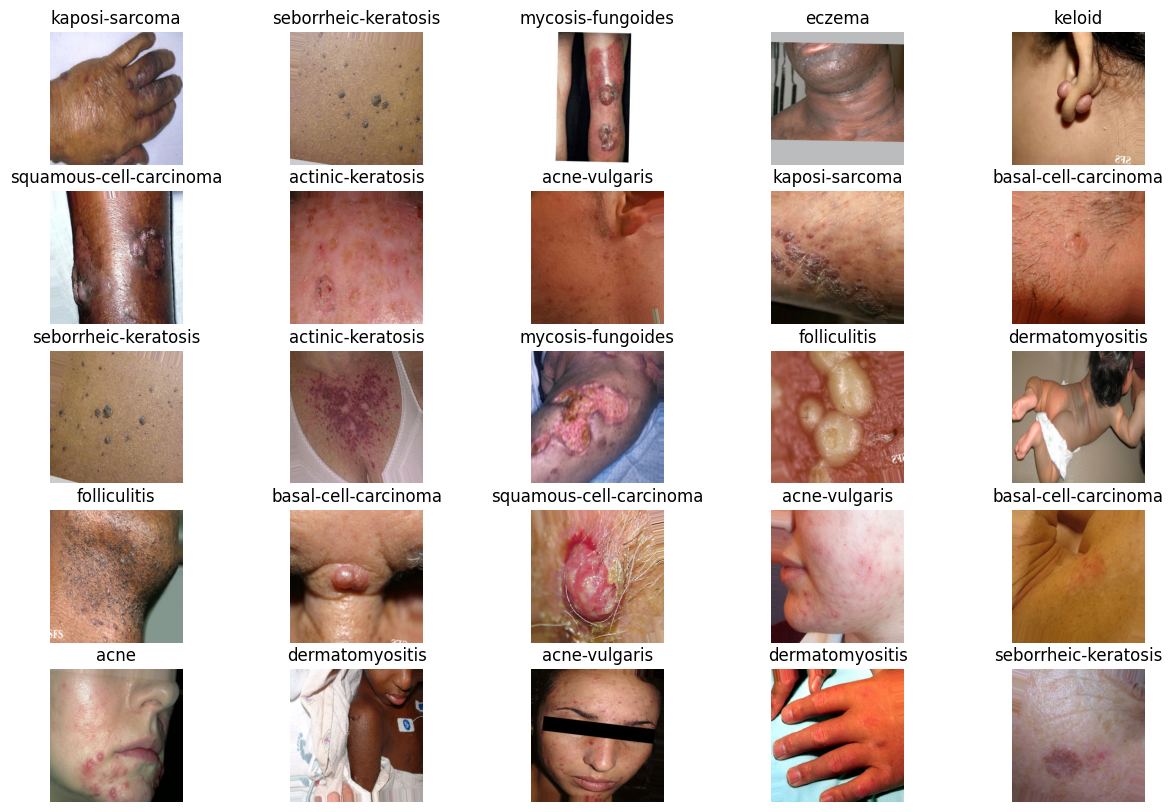

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys())


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)


# Transfer Learning: Xception Model

**add class weight**

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(299, 299, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(299, 299, 3))

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(21, activation = "softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_3 (InputLayer)          │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_1 (Rescaling)             │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 10, 10, 2048)         │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_10              │ (None, 2048)                 │         8,192 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 1024)                 │     2,098,176 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 1024)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_11              │ (None, 1024)                 │         4,096 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_3 (Dense)                     │ (None, 21)                   │        21,525 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 22,993,469 (87.71 MB)

 Trainable params: 2,125,845 (8.11 MB)

 Non-trainable params: 20,867,624 (79.60 MB)

In [ ]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

epochs = 30

print("Fitting the end-to-end model")
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
#history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, class_weight=class_weight_dict)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_3 (InputLayer)          │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_1 (Rescaling)             │ (None, 299, 299, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 10, 10, 2048)         │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_10              │ (None, 2048)                 │         8,192 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 1024)                 │     2,098,176 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 1024)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_11              │ (None, 1024)                 │         4,096 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_3 (Dense)                     │ (None, 21)                   │        21,525 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 22,993,469 (87.71 MB)

 Trainable params: 22,932,797 (87.48 MB)

 Non-trainable params: 60,672 (237.00 KB)

Fitting the end-to-end model
Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 966ms/step - accuracy: 0.1014 - loss: 3.4813 - val_accuracy: 0.0401 - val_loss: 3.3081
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 149s 866ms/step - accuracy: 0.3206 - loss: 2.3926 - val_accuracy: 0.1263 - val_loss: 3.0835
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 850ms/step - accuracy: 0.4804 - loss: 1.8640 - val_accuracy: 0.3608 - val_loss: 2.2479
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 153s 888ms/step - accuracy: 0.5798 - loss: 1.5249 - val_accuracy: 0.5840 - val_loss: 1.4734
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 148s 857ms/step - accuracy: 0.6451 - loss: 1.2608 - val_accuracy: 0.6528 - val_loss: 1.2277
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 147s 853ms/step - accuracy: 0.6951 - loss: 1.1270 - val_accuracy: 0.6604 - val_loss: 1.2602
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 148s 860ms/step - accuracy: 0.7324 - loss: 0.9562 - val_accuracy: 0.7421 - val_loss: 0.9606
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 148s 85

# Plot Training and Validation losss and accuracies

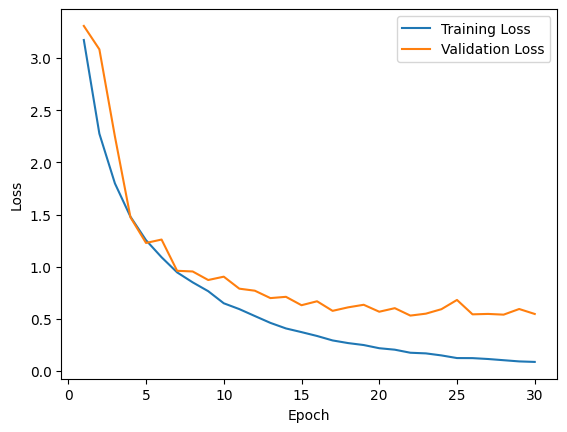

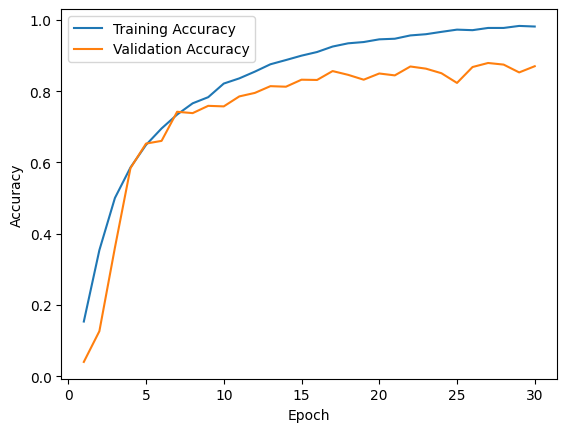

In [ ]:
plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Start preparing submission file

In [ ]:
results = model.predict(test_generator)

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step


In [ ]:
predicted_classes = results.argmax(axis=1)

In [ ]:
print(predicted_classes)

[ 5 10  9 ...  9 15  3]


In [ ]:
categorical_labels = label_encoder.inverse_transform(predicted_classes)
categorical_labels

array(['dermatofibroma', 'folliculitis', 'epidermal-nevus', ...,
       'epidermal-nevus', 'mycosis-fungoides', 'basal-cell-carcinoma'],
      dtype=object)

In [ ]:
testing_dataset.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,qc,ddi_scale,file_path
0,0844ae634f0e6e7ef1f73c2aeecbae0e,2,2,NaN,12,0844ae634f0e6e7ef1f73c2aeecbae0e.jpg
1,3b290d262098f761d719aa07cf36c040,4,3,NaN,34,3b290d262098f761d719aa07cf36c040.jpg
2,cf561d08ac46d0fda678bff6621005ee,2,3,NaN,12,cf561d08ac46d0fda678bff6621005ee.jpg
3,e6371069be05c6b0a95b4b3f1bacc9a5,4,3,NaN,34,e6371069be05c6b0a95b4b3f1bacc9a5.jpg
4,f76cddb37265f97508f159078dcc7e7c,5,5,NaN,56,f76cddb37265f97508f159078dcc7e7c.jpg


In [ ]:
testing_dataset['label'] = categorical_labels
testing_dataset

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,qc,ddi_scale,file_path,label
0,0844ae634f0e6e7ef1f73c2aeecbae0e,2,2,NaN,12,0844ae634f0e6e7ef1f73c2aeecbae0e.jpg,dermatofibroma
1,3b290d262098f761d719aa07cf36c040,4,3,NaN,34,3b290d262098f761d719aa07cf36c040.jpg,folliculitis
2,cf561d08ac46d0fda678bff6621005ee,2,3,NaN,12,cf561d08ac46d0fda678bff6621005ee.jpg,epidermal-nevus
3,e6371069be05c6b0a95b4b3f1bacc9a5,4,3,NaN,34,e6371069be05c6b0a95b4b3f1bacc9a5.jpg,prurigo-nodularis
4,f76cddb37265f97508f159078dcc7e7c,5,5,NaN,56,f76cddb37265f97508f159078dcc7e7c.jpg,actinic-keratosis
...,...,...,...,...,...,...,...
1222,270a217e6e961cf405a4ad46a110ff69,1,1,NaN,12,270a217e6e961cf405a4ad46a110ff69.jpg,eczema
1223,176892dfc10eabf4ad8b1f50ec5df7e5,5,6,NaN,56,176892dfc10eabf4ad8b1f50ec5df7e5.jpg,dermatofibroma
1224,91a4f52d7f99a33ec53d6d695e6c9f4d,2,1,NaN,12,91a4f52d7f99a33ec53d6d695e6c9f4d.jpg,epidermal-nevus
1225,8ba5d48405d01accc3a218693a049ae9,4,2,NaN,34,8ba5d48405d01accc3a218693a049ae9.jpg,mycosis-fungoides


In [ ]:
submission = testing_dataset[['md5hash', 'label']]
submission

,md5hash,label
0,0844ae634f0e6e7ef1f73c2aeecbae0e,dermatofibroma
1,3b290d262098f761d719aa07cf36c040,folliculitis
2,cf561d08ac46d0fda678bff6621005ee,epidermal-nevus
3,e6371069be05c6b0a95b4b3f1bacc9a5,prurigo-nodularis
4,f76cddb37265f97508f159078dcc7e7c,actinic-keratosis
...,...,...
1222,270a217e6e961cf405a4ad46a110ff69,eczema
1223,176892dfc10eabf4ad8b1f50ec5df7e5,dermatofibroma
1224,91a4f52d7f99a33ec53d6d695e6c9f4d,epidermal-nevus
1225,8ba5d48405d01accc3a218693a049ae9,mycosis-fungoides


In [ ]:
submission.to_csv('submission.csv', index=False)